## Introduction to Water Observation From Space (WOfS) Product 



Water Observations from Space (WOfS) is a suite of African continental surface water products that are generated using the WOfS classification algorithm and classifies open water pixels. 
There are several WOfS products in Africa that are listed below:


|WOfS products include:||
|----------|----------------|
| WOfS annual summary | the ratio(%) of wet to clear observations from each calendar year|
| WOfS all-time summary| the ratio(%) of wet to clear observations over time|
| WOfS filtered summary | the all time summary, checked against the confidence layer |
| WOFLs (WOfS Feature Layers)|the daily WOfS slices ||

__WOfS Summary:__ The percentage of time a pixel was classified as wet, using the WOfS classification algorithm. [WOfS Statistics Product Description](https://cmi.ga.gov.au/wo-stats_25_2.1.5)

- Total number of clear observations for the pixel, is a count per pixel of the number of observations that were clear and either wet or dry for the time period.
- Total number of wet observation for the pixel, is a count per pixel of the number of observations that were clear and wet for the time period.
- Summary, is the ratio of clear wet observations to clear wet or dry observation, expressed as a percentage.

__WOfS Filtered Summary:__ The percentage of time a pixel was wet, with confidence. The WOfS Filtered Summary is the definitive product. It has a confidence layer and a filtered summary. The Filtered Summary is the WOfS Summary, and areas with less than 10% confidence have been removed. This piece of information is now under development for Africa. 

__WOfLs (WOfS Feature Layers):__ WOfS Daily observations
    
#### Limitations, Errors and Uncertainty:


http://www.ga.gov.au/scientific-topics/hazards/flood/wofs/about-wofs




## Interacting with WOfS product 

### Load Packages 

In [26]:
%matplotlib inline

#modules for datacube 
import datacube
from datacube.storage import masking
from datacube.utils import geometry
from datacube.utils.geometry import CRS
from datacube.utils.cog import write_cog 
import numpy as np
import pandas as pd 
import seaborn as sn
import xarray as xr 
import sys

#modules for plotting 
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

sys.path.append("../Scripts")
from deafrica_plotting import display_map
from deafrica_datahandling import wofs_fuser, mostcommon_crs

#ignore datacube warnings (needs to be last import statement)
import warnings
warnings.filterwarnings('ignore', module='datacube')

### Connect to the Datacube 

In [27]:
dc = datacube.Datacube(app="Intro_WOfS")

### Listing WOfS products Available in Digital Earth Africa

In [28]:
products = dc.list_products()
display_columns = ['name', 'description']
dc_products = products[display_columns]
dc_products[dc_products['name'].str.contains("wofs")]

,name,description
id,,
7,ga_ls8c_wofs_2,Historic Flood Mapping Water Observations from...
8,ga_ls8c_wofs_2_annual_summary,Water Observations from Space Annual Statistics
10,ga_ls8c_wofs_2_summary,Water Observations from Space Full History Sta...
18,ga_ls8c_wofs_2_terrain,"Water Observations from Space, with terrain mask"


### Analysis Parameters 

The following items are included in the "query" that defines what the datacube need to return:

- **lat/lon:** Latitude and longitude of the area. 
- **time:** Date range to fetch the scenes. The approximate time between two scenes is 16 days. If there is a location near a swath boundary, it may be captured in two passes and so there could be two images within the 16 day period.
- **buffer:** this query is set to run for a point with a buffer around it. 
- **output_crs:** the coordinate reference system of the query. 

In [29]:
#Site location is Lake Sulunga in Tanzania, Africa 

lat, lon =  -6.083 ,35.184
buffer = 0.25

x = (lon-buffer, lon+buffer)
y =  (lat+buffer, lat-buffer)

# Create a reusable query
query = {
    'x': x,
    'y': y,
    'time': ('2015-01-01', '2019-03-20'),
    'resolution': (-30, 30)
}

output_crs = mostcommon_crs(dc=dc, product='ga_ls8c_wofs_2', query=query)

../Scripts/deafrica_datahandling.py:600: UserWarning: Multiple UTM zones ['epsg:32636', 'epsg:32637'] were returned for this query. Defaulting to the most common zone: epsg:32636
  UserWarning)


### View the Selected Location

In [38]:
#view the location 
display_map(x=x, y=y)

## WOfS Feature Layers (WOFLs) 

In [31]:
#load wofs feature layers 
wofls= dc.load(product = 'ga_ls8c_wofs_2',group_by="solar_day",fuse_func=wofs_fuser, output_crs = output_crs,**query)
wofls

<xarray.Dataset>
Dimensions:      (time: 190, x: 1853, y: 1852)
Coordinates:
  * time         (time) datetime64[ns] 2015-01-05T07:44:25.672915 ... 2019-03-12T07:50:10.449636
  * y            (y) float64 -6.451e+05 -6.451e+05 ... -7.006e+05 -7.006e+05
  * x            (x) float64 7.14e+05 7.14e+05 7.14e+05 ... 7.695e+05 7.695e+05
    spatial_ref  int32 32636
Data variables:
    water        (time, y, x) uint8 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1 1
Attributes:
    crs:           epsg:32636
    grid_mapping:  spatial_ref

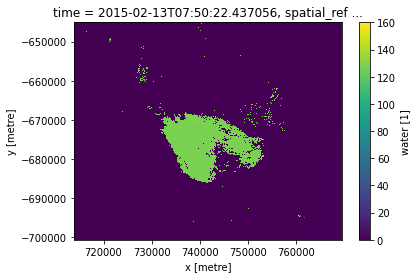

In [32]:
# Show areas that are water in specific time span 
wofls.water.isel(time=5).plot()

WOfS uses [bit flags](http://datacube-core.readthedocs.io/en/latest/dev/api/masking.html) to flag pixels as 'wet' or otherwise. For more details on how to do masking on WOfS, see the [Applying_WOfS_bit_masking](../Frequently_used_code/Applying_WOfS_bitmasking.ipynb) notebook.

### WOFL Masks in One Timestep

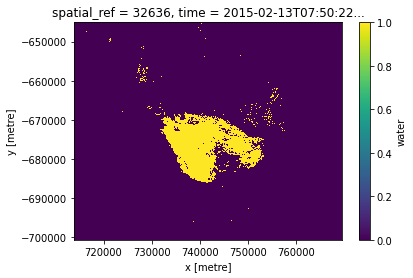

In [33]:
wetwofl = masking.make_mask(wofls, wet=True)
wetwofl.water.isel(time=5).plot()

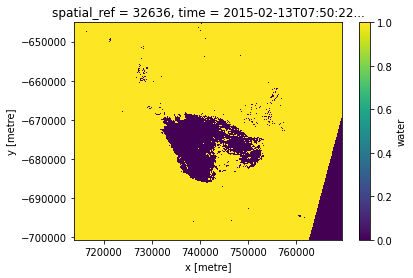

In [34]:
drywofl = masking.make_mask(wofls, dry=True)
drywofl.water.isel(time=5).plot()

### Percentage of the Time that the Lake was Wet

In [35]:
freq= dc.load(product = 'ga_ls8c_wofs_2_summary', output_crs = output_crs,**query)

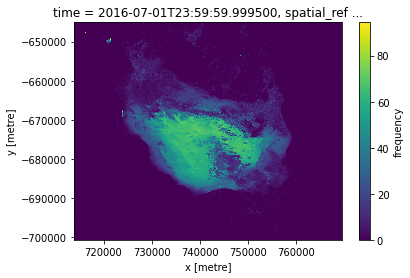

In [36]:
(freq.frequency*100).plot()

## Save WOFL to Cloud Optimised Geotiff (COG)

This method uses the `datacube.utils.cog` function [write_cog](https://datacube-core.readthedocs.io/en/latest/dev/api/generate/datacube.utils.cog.write_cog.html), where cog stands for [Cloud-Optimised-Geotiff](https://www.cogeo.org/) to export a simple single-band, single time-slice COG. 

A few important caveats should be noted when using this function:
1. It requires an `xarray.DataArray`; supplying an `xarray.Dataset` will return an error. To convert a `xarray.Dataset` to an array run the following: 

        da = ds.to_array()

2. This function generates a temporary in-memory tiff file without compression.  This means the function will use about 1.5 to 2 times the memory required using the depreciated `datacube.helper.write_geotiff`.

3. If you pass a `dask array` into the function, `write_cog` will not output a geotiff, but will instead return a` Dask Delayed` object. To trigger the output of the geotiff run `.compute()` on the dask delayed object: 

        write_cog(ds.red.isel(time=0), "red.tif").compute()

In [37]:
# Write the wofls query as COG format 
write_cog(wofls.water.isel(time=5),fname="wofls_saved",overwrite=True)

PosixPath('wofls_saved')

For more examples on how WOfS can be used for water resource management, also see the [Water_extent](../Real_world_examples/Water_extent.ipynb) notebook in this sandbox.

## References

github repo https://github.com/GeoscienceAustralia/wofs

Mueller, et al. 2015., *Water observations from space: Mapping surface water from 25 years of Landsat imagery across Australia*, Remote Sensing of Environment. https://doi.org/10.1016/j.rse.2015.11.003

GA, 2017. *Water Observations from Space 2.1.5 Product Description.* https://cmi.ga.gov.au/wo_25_2.1.5

GA, 2017. *Water Observations from Space Statistics 25m 2.1.5*, https://cmi.ga.gov.au/wo-stats_25_2.1.5

GA, 2017. *Water Observations from Space Filtered Statistics 25m 2.1.5 Product Description*
https://data.dea.ga.gov.au/WOfS/filtered_summary/v2.1.0/Product%20Description.pdf